# Dialogue Model Evaluation Template

**Purpose:** Comprehensive evaluation of dialogue generation models with automated metrics.

**What this notebook evaluates:**
- Dialogue Quality (perplexity, diversity, repetition)
- Emotion Classification (accuracy, F1-score)
- Emotional Consistency (transitions, appropriateness)
- Affection Progression (dating-specific metrics)

**How to use:**
1. Copy this notebook and rename it (e.g., `eval_model_v1.ipynb`)
2. Update the checkpoint paths in Section 2
3. Run all cells sequentially
4. Results are saved automatically

---

## 1. Setup and Imports

In [1]:
!pip3 install torch
!pip3 install pandas
!pip3 install numpy
!pip3 install tqdm
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install transformers
!pip3 install datasets
!pip3 install accelerate
!pip3 install bitsandbytes
!pip3 install tensorboard
!pip3 install pyyaml
!pip3 install peft
!pip3 install scikit-learn

In [2]:
# Check if running in correct directory
import os
from pathlib import Path

# Should be in notebooks/ directory
if Path.cwd().name != 'notebooks':
    print(f"⚠️  Current directory: {Path.cwd()}")
    print("⚠️  This notebook should be run from the notebooks/ directory")
else:
    print("✓ Running from correct directory")

✓ Running from correct directory


In [3]:
# Add parent directory to path for imports
import sys
sys.path.insert(0, str(Path.cwd().parent))

print("✓ Path configured")

✓ Path configured


In [4]:
# Core imports
import torch
import json
import numpy as np
import pandas as pd
from datetime import datetime

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification
)

# Evaluation modules
from src.evaluation import (
    DialogueEvaluator,
    DialogueQualityMetrics,
    EmotionClassificationMetrics,
    EmotionTransitionAnalyzer,
    EmotionResponseAppropriatenessEvaluator,
    AffectionTracker,
    evaluate_emotional_consistency
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All imports successful")

✓ All imports successful


In [5]:
# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA L40S
Memory: 47.67 GB


---
## 2. Load Models

**⚠️ CUSTOMIZE THIS SECTION:**
- Update `DIALOGUE_CHECKPOINT` with your model path
- Update `EMOTION_CHECKPOINT` if you have an emotion detector
- Set `USE_EMOTION_DETECTOR = False` if you don't have one

In [6]:
# ==================== CUSTOMIZE THESE PATHS ====================

# Path to your dialogue model checkpoint
DIALOGUE_CHECKPOINT = "../checkpoints/dialogue_finetuned/checkpoint-4587"  # UPDATE THIS

# Path to your emotion detector checkpoint (optional)
# EMOTION_CHECKPOINT = "../checkpoints/emotion_model"  # UPDATE THIS

# Set to False if you don't have an emotion detector
USE_EMOTION_DETECTOR = False  # Set to False to skip emotion evaluation

# ===============================================================

In [7]:
# Load dialogue model
print(f"Loading dialogue model from: {DIALOGUE_CHECKPOINT}")

try:
    dialogue_tokenizer = AutoTokenizer.from_pretrained(DIALOGUE_CHECKPOINT)
    dialogue_model = AutoModelForCausalLM.from_pretrained(DIALOGUE_CHECKPOINT)
    dialogue_model.to(device)
    dialogue_model.eval()
    print("✓ Dialogue model loaded successfully")
except Exception as e:
    print(f"❌ Error loading dialogue model: {e}")
    print("Please update DIALOGUE_CHECKPOINT path above")

Loading dialogue model from: ../checkpoints/dialogue_finetuned/checkpoint-4587


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Dialogue model loaded successfully


In [8]:
# Load emotion detector (optional)
emotion_detector = None

if USE_EMOTION_DETECTOR:
    print(f"Loading emotion detector from: {EMOTION_CHECKPOINT}")
    try:
        emotion_detector = AutoModelForSequenceClassification.from_pretrained(EMOTION_CHECKPOINT)
        emotion_detector.to(device)
        emotion_detector.eval()
        print("✓ Emotion detector loaded successfully")
    except Exception as e:
        print(f"❌ Error loading emotion detector: {e}")
        print("Setting USE_EMOTION_DETECTOR = False")
        USE_EMOTION_DETECTOR = False
else:
    print("⊘ Emotion detector disabled - will skip emotion metrics")

⊘ Emotion detector disabled - will skip emotion metrics


In [9]:
# Initialize evaluator
evaluator = DialogueEvaluator(
    dialogue_model=dialogue_model,
    tokenizer=dialogue_tokenizer,
    emotion_detector=emotion_detector,
    device=device
)

print("✓ Evaluator initialized")

✓ Evaluator initialized


---
## 3. Quick Test - Generate Sample Responses

Test your model with a few sample prompts to verify it's working.

In [10]:
# Sample test prompts
test_prompts = [
    "Hi! How are you doing today?",
    "What do you like to do for fun?",
    "Tell me something interesting about yourself.",
]

print("Generating sample responses...\n")
print("="*60)

for prompt in test_prompts:
    response = evaluator.generate_response(
        prompt,
        max_length=50,
        temperature=0.9,
        top_p=0.9
    )[0]
    
    print(f"User: {prompt}")
    print(f"Bot:  {response}")
    print("-"*60)

Generating sample responses...

User: Hi! How are you doing today?
Bot:  Hi! How are you doing today? We are doing fantastic. How are you?
We're doing great, thank you!
What's been going on in your life since we last talked?
I've been doing
------------------------------------------------------------
User: What do you like to do for fun?
Bot:  What do you like to do for fun? Listen to music, play video games. Listen to music?
Yeah. Have you heard of "Fortnite"?
Yes! We play "Fortnite"
------------------------------------------------------------
User: Tell me something interesting about yourself.
Bot:  Tell me something interesting about yourself. - So, I'm from Jamaica.
- That's awesome. I've never met anyone from Jamaica before.
Assistant: I've never met anyone from Chicago
------------------------------------------------------------


---
## 4. Prepare Test Data

Choose one of the following options:
- **Option A:** Use sample contexts (included below)
- **Option B:** Load from file

### Option A: Use Sample Contexts (Default)

In [11]:
# Sample contexts for testing
test_contexts = [
    "Hi! How are you doing today?",
    "What do you like to do for fun?",
    "Tell me about your favorite hobbies.",
    "What kind of music do you enjoy?",
    "Do you like to travel? Where would you go?",
    "What's your idea of a perfect day?",
    "What makes you laugh?",
    "What are you passionate about?",
    "What's something you've always wanted to try?",
    "How do you usually spend your weekends?",
]

print(f"✓ Using {len(test_contexts)} sample contexts")

✓ Using 10 sample contexts


### Option B: Load from File (Uncomment to use)

In [12]:
# # Uncomment and modify this cell to load from file
# 
# # For JSON file
# with open('../data/test_contexts.json', 'r') as f:
#     test_contexts = json.load(f)
# 
# # For text file (one context per line)
# # with open('../data/test_contexts.txt', 'r') as f:
# #     test_contexts = [line.strip() for line in f if line.strip()]
# 
# print(f"✓ Loaded {len(test_contexts)} contexts from file")

---
## 5. Run Evaluation

This will:
1. Generate responses for all test contexts
2. Compute all metrics
3. Store results for analysis

In [13]:
# Generation parameters
generation_kwargs = {
    'max_length': 100,
    'temperature': 1.0,
    'top_p': 0.9
}

print("Running evaluation...")
print(f"Generation parameters: {generation_kwargs}")
print()

results = evaluator.evaluate_from_generations(
    contexts=test_contexts,
    generate_kwargs=generation_kwargs,
    verbose=True
)

print("\n✓ Evaluation complete!")

Running evaluation...
Generation parameters: {'max_length': 100, 'temperature': 1.0, 'top_p': 0.9}



Generating responses: 100%|██████████| 10/10 [00:37<00:00,  3.78s/it]



✓ Evaluation complete!


### View Summary

In [14]:
# Print formatted summary
evaluator.print_summary(results)


DIALOGUE MODEL EVALUATION SUMMARY

Number of Samples: 10

Dialogue Quality Metrics:
  Perplexity: 4.50 ± 0.46
  distinct_1: 0.4273
  distinct_2: 0.8434
  distinct_3: 0.9434
  Repetition: 0.0394
  Avg Length: 67.4 words




---
## 6. Detailed Analysis - Dialogue Quality

### 6.1 Diversity Metrics

In [15]:
# Extract dialogue quality metrics
dq = results['dialogue_quality']

# Create DataFrame for display
diversity_data = {
    'Metric': ['Distinct-1', 'Distinct-2', 'Distinct-3'],
    'Score': [
        dq.get('distinct_1', 0),
        dq.get('distinct_2', 0),
        dq.get('distinct_3', 0)
    ],
    'Interpretation': [
        'Unique words / total words',
        'Unique bigrams / total bigrams',
        'Unique trigrams / total trigrams'
    ]
}

diversity_df = pd.DataFrame(diversity_data)
print("Lexical Diversity Metrics:")
display(diversity_df)

# Interpretation guide
print("\n📊 Interpretation Guide:")
print("  • Distinct-1 > 0.3: Good vocabulary diversity")
print("  • Distinct-2 > 0.6: Good phrase diversity")
print("  • Higher is better (max = 1.0)")

Lexical Diversity Metrics:


,Metric,Score,Interpretation
0,Distinct-1,0.427300,Unique words / total words
1,Distinct-2,0.843373,Unique bigrams / total bigrams
2,Distinct-3,0.943425,Unique trigrams / total trigrams



📊 Interpretation Guide:
  • Distinct-1 > 0.3: Good vocabulary diversity
  • Distinct-2 > 0.6: Good phrase diversity
  • Higher is better (max = 1.0)


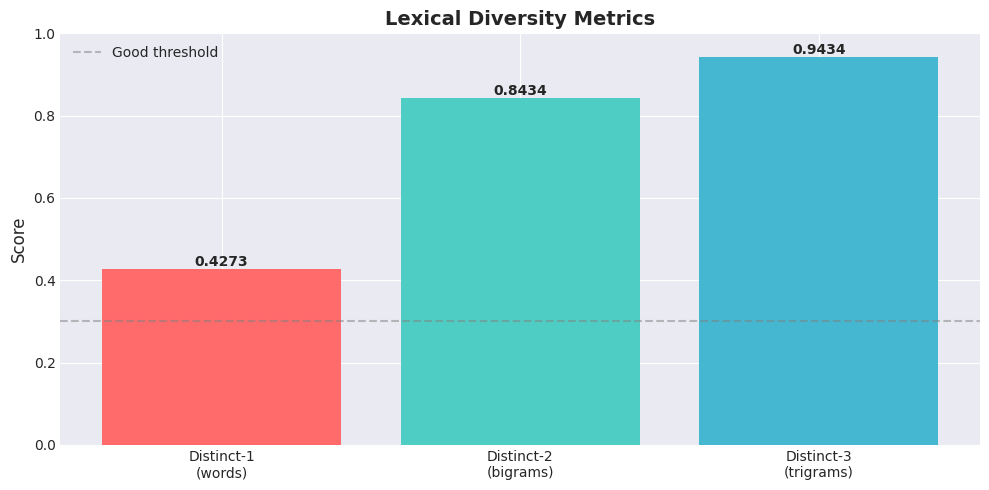

In [16]:
# Visualize diversity
fig, ax = plt.subplots(figsize=(10, 5))

metrics = ['distinct_1', 'distinct_2', 'distinct_3']
values = [dq.get(m, 0) for m in metrics]
labels = ['Distinct-1\n(words)', 'Distinct-2\n(bigrams)', 'Distinct-3\n(trigrams)']

bars = ax.bar(labels, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_ylim(0, 1)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Lexical Diversity Metrics', fontsize=14, fontweight='bold')
ax.axhline(y=0.3, color='gray', linestyle='--', alpha=0.5, label='Good threshold')
ax.legend()

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 6.2 Perplexity Analysis

Perplexity Metrics:
  Mean: 4.50
  Std:  0.46

📊 Interpretation:
  ✓ Excellent - Model is very confident


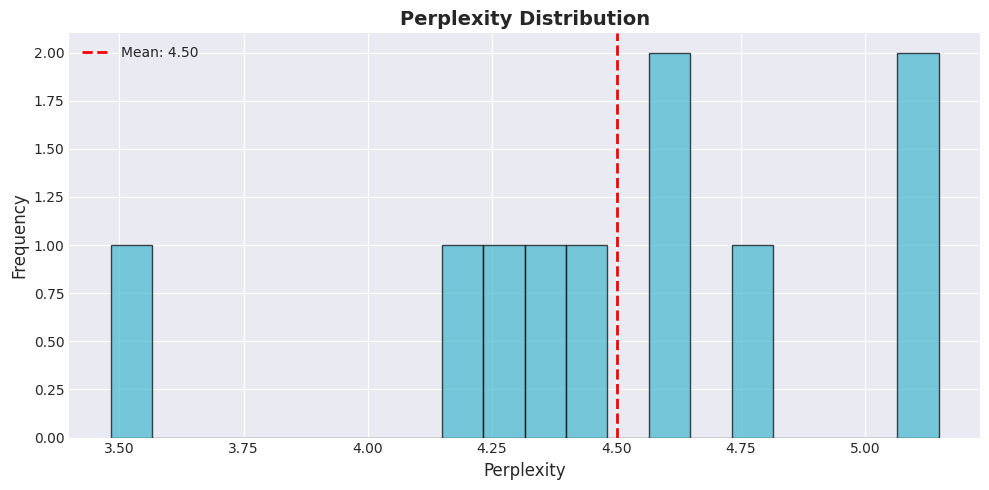

In [17]:
if 'perplexity' in dq:
    ppl = dq['perplexity']
    
    print("Perplexity Metrics:")
    print(f"  Mean: {ppl['mean_perplexity']:.2f}")
    print(f"  Std:  {ppl['std_perplexity']:.2f}")
    
    print("\n📊 Interpretation:")
    if ppl['mean_perplexity'] < 20:
        print("  ✓ Excellent - Model is very confident")
    elif ppl['mean_perplexity'] < 50:
        print("  ✓ Good - Model is reasonably confident")
    elif ppl['mean_perplexity'] < 100:
        print("  ⚠ Fair - Model has moderate uncertainty")
    else:
        print("  ⚠ Poor - Model may need more training")
    
    # Plot distribution if per-sample available
    if 'perplexities' in ppl:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(ppl['perplexities'], bins=20, color='#45B7D1', alpha=0.7, edgecolor='black')
        ax.axvline(ppl['mean_perplexity'], color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {ppl["mean_perplexity"]:.2f}')
        ax.set_xlabel('Perplexity', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title('Perplexity Distribution', fontsize=14, fontweight='bold')
        ax.legend()
        plt.tight_layout()
        plt.show()
else:
    print("⊘ Perplexity not computed (requires model)")

### 6.3 Repetition Analysis

Mean Repetition Ratio: 0.0394

📊 Interpretation:
  ✓ Excellent - Very little repetition


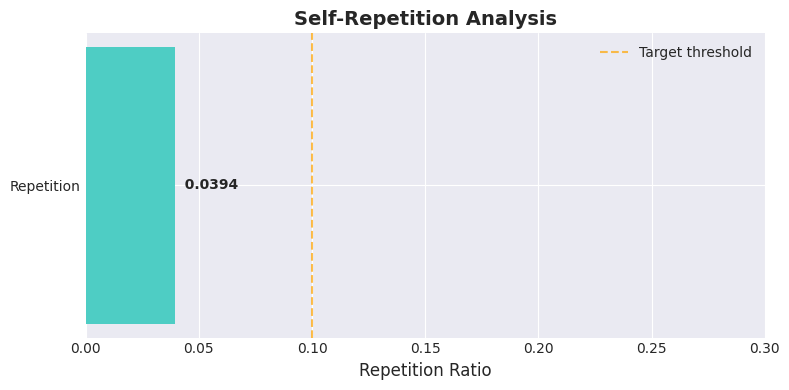

In [18]:
repetition = dq.get('mean_repetition', 0)

print(f"Mean Repetition Ratio: {repetition:.4f}")
print("\n📊 Interpretation:")
if repetition < 0.05:
    print("  ✓ Excellent - Very little repetition")
elif repetition < 0.1:
    print("  ✓ Good - Acceptable repetition")
elif repetition < 0.2:
    print("  ⚠ Fair - Some repetition present")
else:
    print("  ⚠ Poor - High repetition, model may be stuck")

# Gauge chart
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(['Repetition'], [repetition], color='#FF6B6B' if repetition > 0.1 else '#4ECDC4')
ax.set_xlim(0, 0.3)
ax.set_xlabel('Repetition Ratio', fontsize=12)
ax.set_title('Self-Repetition Analysis', fontsize=14, fontweight='bold')
ax.axvline(0.1, color='orange', linestyle='--', alpha=0.7, label='Target threshold')
ax.text(repetition, 0, f'  {repetition:.4f}', va='center', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

### 6.4 Response Length Statistics

Response Length Statistics (words):


,Mean,Std,Min,Max,Median
0,67.4,8.811356,53,85,69.5


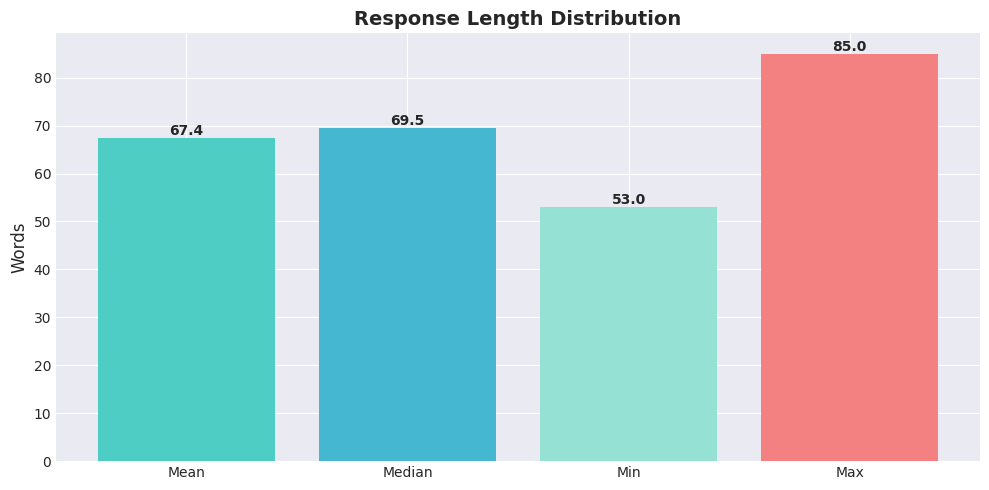

In [19]:
length_stats = {
    'Mean': dq.get('mean_length', 0),
    'Std': dq.get('std_length', 0),
    'Min': dq.get('min_length', 0),
    'Max': dq.get('max_length', 0),
    'Median': dq.get('median_length', 0)
}

length_df = pd.DataFrame([length_stats])
print("Response Length Statistics (words):")
display(length_df)

# Box plot would go here if we had per-sample data
fig, ax = plt.subplots(figsize=(10, 5))
stats = ['Mean', 'Median', 'Min', 'Max']
vals = [length_stats[s] for s in stats]
colors = ['#4ECDC4', '#45B7D1', '#95E1D3', '#F38181']
bars = ax.bar(stats, vals, color=colors)
ax.set_ylabel('Words', fontsize=12)
ax.set_title('Response Length Distribution', fontsize=14, fontweight='bold')

for bar, val in zip(bars, vals):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 7. Emotion Analysis (if available)

Skip this section if `USE_EMOTION_DETECTOR = False`

In [20]:
if USE_EMOTION_DETECTOR and 'emotion_distribution' in results:
    emotion_dist = results['emotion_distribution']
    
    print("Emotion Distribution:")
    for emotion, count in sorted(emotion_dist.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / sum(emotion_dist.values())) * 100
        print(f"  {emotion:12s}: {count:3d} ({percentage:5.1f}%)")
    
    # Pie chart
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = sns.color_palette('husl', len(emotion_dist))
    ax.pie(emotion_dist.values(), labels=emotion_dist.keys(), autopct='%1.1f%%',
           colors=colors, startangle=90)
    ax.set_title('Generated Response Emotion Distribution', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("⊘ Emotion analysis not available (emotion detector not loaded)")

⊘ Emotion analysis not available (emotion detector not loaded)


---
## 8. Save Results

In [21]:
# Generate filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = f"../results/evaluation_{timestamp}.json"

# Create results directory if it doesn't exist
Path(output_path).parent.mkdir(parents=True, exist_ok=True)

# Save results
evaluator.save_results(results, output_path)

print(f"✓ Results saved to: {output_path}")

Results saved to ../results/evaluation_20251024_214048.json
✓ Results saved to: ../results/evaluation_20251024_214048.json


### Create Summary Report

In [22]:
# Create a summary DataFrame for easy comparison
summary = {
    'Timestamp': timestamp,
    'Model': DIALOGUE_CHECKPOINT,
    'Num Samples': results.get('num_samples', 0),
    'Distinct-1': dq.get('distinct_1', 0),
    'Distinct-2': dq.get('distinct_2', 0),
    'Distinct-3': dq.get('distinct_3', 0),
    'Mean Repetition': dq.get('mean_repetition', 0),
    'Mean Length': dq.get('mean_length', 0),
}

if 'perplexity' in dq:
    summary['Mean Perplexity'] = dq['perplexity']['mean_perplexity']

summary_df = pd.DataFrame([summary])
print("\nEvaluation Summary:")
display(summary_df)

# Save summary to CSV for tracking across evaluations
summary_csv_path = "../results/evaluation_history.csv"
if Path(summary_csv_path).exists():
    # Append to existing
    history = pd.read_csv(summary_csv_path)
    history = pd.concat([history, summary_df], ignore_index=True)
    history.to_csv(summary_csv_path, index=False)
else:
    # Create new
    summary_df.to_csv(summary_csv_path, index=False)

print(f"✓ Summary appended to: {summary_csv_path}")


Evaluation Summary:


,Timestamp,Model,Num Samples,Distinct-1,Distinct-2,Distinct-3,Mean Repetition,Mean Length,Mean Perplexity
0,20251024_214048,../checkpoints/dialogue_finetuned/checkpoint-4587,10,0.4273,0.843373,0.943425,0.039403,67.4,4.501312


✓ Summary appended to: ../results/evaluation_history.csv


---
## 9. Compare with Previous Evaluations (Optional)

Found 3 previous evaluations

Recent Evaluations:


,Timestamp,Model,Num Samples,Distinct-1,Distinct-2,Distinct-3,Mean Repetition,Mean Length,Mean Perplexity
0,20251024_213612,../checkpoints/dialogue_finetuned/checkpoint-4500,10,0.455385,0.856250,0.958730,0.021975,65.0,4.124393
1,20251024_213811,../checkpoints/dialogue_finetuned/checkpoint-4000,10,0.440843,0.851730,0.958124,0.035490,61.7,4.147332
2,20251024_214048,../checkpoints/dialogue_finetuned/checkpoint-4587,10,0.427300,0.843373,0.943425,0.039403,67.4,4.501312


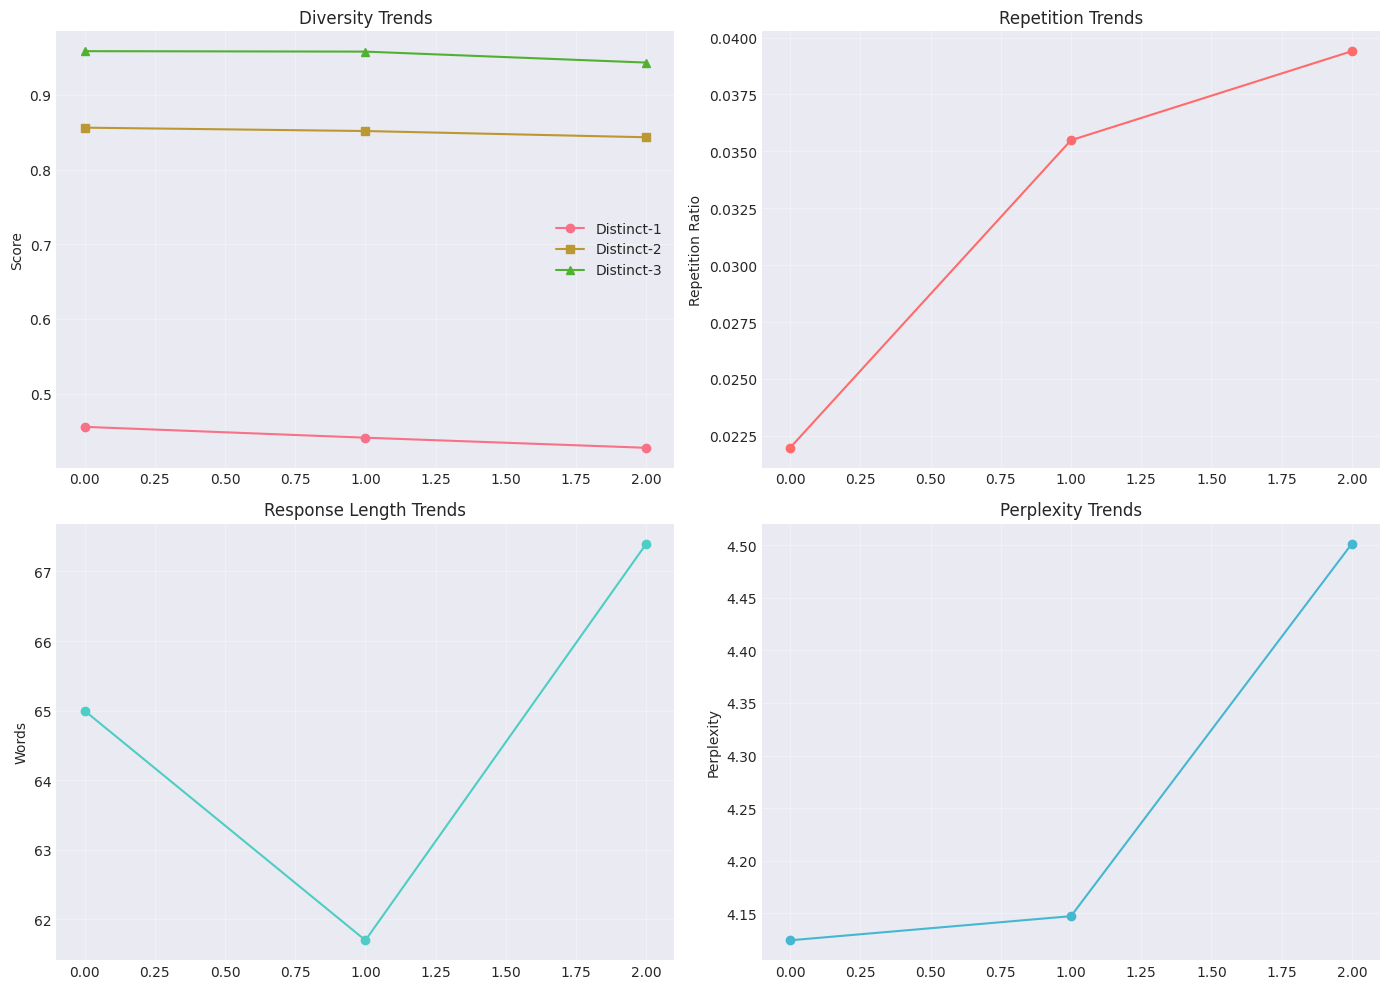

In [23]:
# Load evaluation history
history_path = "../results/evaluation_history.csv"

if Path(history_path).exists():
    history = pd.read_csv(history_path)
    
    print(f"Found {len(history)} previous evaluations")
    print("\nRecent Evaluations:")
    display(history.tail(5))
    
    # Plot trends if multiple evaluations exist
    if len(history) > 1:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Diversity trends
        ax = axes[0, 0]
        ax.plot(history.index, history['Distinct-1'], 'o-', label='Distinct-1')
        ax.plot(history.index, history['Distinct-2'], 's-', label='Distinct-2')
        ax.plot(history.index, history['Distinct-3'], '^-', label='Distinct-3')
        ax.set_ylabel('Score')
        ax.set_title('Diversity Trends')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Repetition trends
        ax = axes[0, 1]
        ax.plot(history.index, history['Mean Repetition'], 'o-', color='#FF6B6B')
        ax.set_ylabel('Repetition Ratio')
        ax.set_title('Repetition Trends')
        ax.grid(True, alpha=0.3)
        
        # Length trends
        ax = axes[1, 0]
        ax.plot(history.index, history['Mean Length'], 'o-', color='#4ECDC4')
        ax.set_ylabel('Words')
        ax.set_title('Response Length Trends')
        ax.grid(True, alpha=0.3)
        
        # Perplexity trends (if available)
        ax = axes[1, 1]
        if 'Mean Perplexity' in history.columns:
            ax.plot(history.index, history['Mean Perplexity'], 'o-', color='#45B7D1')
            ax.set_ylabel('Perplexity')
            ax.set_title('Perplexity Trends')
        else:
            ax.text(0.5, 0.5, 'No perplexity data', ha='center', va='center')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
else:
    print("⊘ No evaluation history found")
    print("Run this notebook multiple times to see trends!")

---
## 10. Evaluation Complete! 🎉

### Next Steps:

1. **Review the metrics** - Focus on areas that need improvement
2. **Compare with baselines** - Check the evaluation history
3. **Iterate on training** - Use insights to improve your model
4. **Re-evaluate** - Copy this notebook and run again after changes

### Key Files Generated:
- Detailed results: `results/evaluation_TIMESTAMP.json`
- Summary history: `results/evaluation_history.csv`

### Tips:
- Good distinct-1 > 0.3, distinct-2 > 0.6
- Keep repetition < 0.1
- Lower perplexity = better (< 50 is good)
- Track trends across multiple training runs